In [28]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [29]:
import torch
from PFNExperiments.Evaluation.Evaluate import Evaluate
from pyro.infer.autoguide import AutoMultivariateNormal
from PFNExperiments.LinearRegression.ComparisonModels.Hamiltionion_MC import Hamiltionian_MC
from PFNExperiments.LinearRegression.ComparisonModels.Variational_InferenceAutoguide import Variational_InferenceAutoguide

from PFNExperiments.LinearRegression.GenerativeModels.Curriculum import Curriculum
from PFNExperiments.LinearRegression.GenerativeModels.GenerateDataCurriculumCFM import GenerateDataCurriculumCFM
from PFNExperiments.LinearRegression.GenerativeModels.LM_abstract import return_only_y, print_code

from PFNExperiments.LinearRegression.GenerativeModels.TargetScaler import TargetScaler

In [30]:
from PFNExperiments.LinearRegression.GenerativeModels.GenerateDataLM_TargetDist import make_lm_program_ig_gamma_response_intercept_gamma_reparam, make_lm_program_ig_gamma_response_intercept_gamma_reparam_batched

#scaler_pprogram_maker = TargetScaler(transform="standardize")

#make_lm_program = scaler_pprogram_maker.transform_y(make_lm_program_beta_prior)
#make_lm_program_batched = scaler_pprogram_maker.transform_y_batched(make_lm_program_beta_prior_batched)

make_lm_program = make_lm_program_ig_gamma_response_intercept_gamma_reparam
make_lm_program_batched = make_lm_program_ig_gamma_response_intercept_gamma_reparam_batched

pprogram_batched = make_lm_program_batched()
pprogram = make_lm_program()


pprogram_y = return_only_y(pprogram)

a = 5.0
b = 2.0
tau = 1.0
tau_beta0 = 3.0**0.5


curriculum = Curriculum(max_iter=int(1))
curriculum.add_param_list(
    [
    ("tau", curriculum.constant_scheduler(tau)),
    ("a", curriculum.constant_scheduler(a)),
    ("b", curriculum.constant_scheduler(b)),
    ("tau_beta0", curriculum.constant_scheduler(tau_beta0)),

    ]
)

"""
curriculum = Curriculum(max_iter=int(1))
curriculum.add_param_list(
    [
    ("tau", curriculum.constant_scheduler(0.1)),
    ("a", curriculum.constant_scheduler(a)),
    ("b", curriculum.constant_scheduler(b)),
    ]
)
"""


#gammma_lambda: float = 1.0,
#gamma_tausquared: float = 1.0,
#a: float = 5.0,
#b: float = 2.0


'\ncurriculum = Curriculum(max_iter=int(1))\ncurriculum.add_param_list(\n    [\n    ("tau", curriculum.constant_scheduler(0.1)),\n    ("a", curriculum.constant_scheduler(a)),\n    ("b", curriculum.constant_scheduler(b)),\n    ]\n)\n'

In [31]:
data_generator = GenerateDataCurriculumCFM(
    pprogram_maker= make_lm_program_batched,
    curriculum= curriculum,
    #coupling = None
)

pprogram_covariates_train is None, using pprogram_covariates instead
pprogram_covariates_val is None, using pprogram_covariates instead
pprogram_covariates_test is None, using pprogram_covariates instead


In [32]:

"""
data_generator.check_model(
    n_samples_per_epoch=10,
    batch_size=32,
    used_batch_samples=3
    )
"""

'\ndata_generator.check_model(\n    n_samples_per_epoch=10,\n    batch_size=32,\n    used_batch_samples=3\n    )\n'

In [33]:
dataloader_train, dataloader_val, dataloader_test = data_generator.make_dataloaders_for_epoch_dynamic(epoch = 0, n = 100, p = 5, n_samples_per_epoch=100, batch_size=32)

In [34]:
test = next(iter(dataloader_train))

In [35]:
test['y'].shape

torch.Size([32, 100])


      var: 0.4075675308704376
      mean: 1.0303027629852295
        


(array([13., 17., 24., 15., 12.,  6.,  5.,  5.,  2.,  1.]),
 array([0.02789796, 0.33121744, 0.63453692, 0.93785644, 1.24117589,
        1.54449546, 1.84781492, 2.15113449, 2.45445395, 2.7577734 ,
        3.06109285]),
 <BarContainer object of 10 artists>)

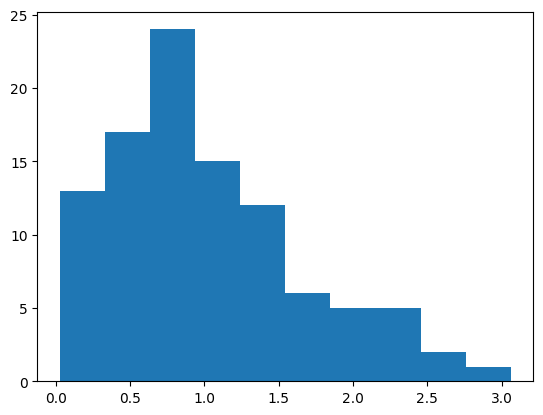

In [42]:
import matplotlib.pyplot as plt
idx =25
y_data = test['y'][idx]
print(f"""
      var: {y_data.var()}
      mean: {y_data.mean()}
        """)
plt.hist(test['y'][idx])

In [16]:
N_SAMPLES_PER_MODEL = 1000

In [17]:
pprogram = make_lm_program(**data_generator.curriculum.get_params(-1))
pprogram_y = return_only_y(pprogram)


In [23]:
hmc_sampler = Hamiltionian_MC(pprogram = pprogram_y, n_warmup=500, n_samples=N_SAMPLES_PER_MODEL)

vi_multivariate_normal = Variational_InferenceAutoguide(
    pprogram=pprogram_y,
    make_guide_fun = AutoMultivariateNormal,
    n_steps = 2000,
    n_samples=N_SAMPLES_PER_MODEL,
    lr = 1e-2
)

In [24]:
from PFNExperiments.Evaluation.CompareModelToGT import CompareModelToGT

In [25]:
from PFNExperiments.Evaluation.Evaluate import just_return_results, results_dict_to_latent_variable_beta0_and_beta

evaluation = Evaluate(
    posterior_model = hmc_sampler,
    evaluation_loader = dataloader_train,
    comparison_models= [vi_multivariate_normal
                        ],
    n_evaluation_cases=10,
    save_path= None,
    overwrite_results = True,
    results_dict_to_latent_variable_posterior_model=results_dict_to_latent_variable_beta0_and_beta,
    results_dict_to_latent_variable_comparison_models=results_dict_to_latent_variable_beta0_and_beta,
    compare_to_gt = CompareModelToGT(
        #results_dict_to_latent_variable = results_dict_to_latent_variable_beta0_and_beta,
    )
)

In [26]:
evaluation.run_evaluation()

Sampling posterior:  10%|█         | 1/10 [04:03<36:34, 243.86s/it]


        shape beta0: torch.Size([1000, 1])
        shape beta: torch.Size([1000, 5])
        shape beta_combined: torch.Size([1000, 6])



Sampling posterior:  20%|██        | 2/10 [07:29<29:29, 221.18s/it]


        shape beta0: torch.Size([1000, 1])
        shape beta: torch.Size([1000, 5])
        shape beta_combined: torch.Size([1000, 6])



Sampling posterior:  30%|███       | 3/10 [10:36<23:59, 205.70s/it]


        shape beta0: torch.Size([1000, 1])
        shape beta: torch.Size([1000, 5])
        shape beta_combined: torch.Size([1000, 6])



Sampling posterior:  40%|████      | 4/10 [14:35<21:53, 218.85s/it]


        shape beta0: torch.Size([1000, 1])
        shape beta: torch.Size([1000, 5])
        shape beta_combined: torch.Size([1000, 6])



Sampling posterior:  50%|█████     | 5/10 [18:41<19:03, 228.69s/it]


        shape beta0: torch.Size([1000, 1])
        shape beta: torch.Size([1000, 5])
        shape beta_combined: torch.Size([1000, 6])



Sampling posterior:  60%|██████    | 6/10 [24:43<18:16, 274.15s/it]


        shape beta0: torch.Size([1000, 1])
        shape beta: torch.Size([1000, 5])
        shape beta_combined: torch.Size([1000, 6])



Sampling posterior:  70%|███████   | 7/10 [27:37<12:03, 241.09s/it]


        shape beta0: torch.Size([1000, 1])
        shape beta: torch.Size([1000, 5])
        shape beta_combined: torch.Size([1000, 6])



Sampling posterior:  80%|████████  | 8/10 [30:14<07:09, 214.56s/it]


        shape beta0: torch.Size([1000, 1])
        shape beta: torch.Size([1000, 5])
        shape beta_combined: torch.Size([1000, 6])



Sampling posterior:  90%|█████████ | 9/10 [32:32<03:10, 190.41s/it]


        shape beta0: torch.Size([1000, 1])
        shape beta: torch.Size([1000, 5])
        shape beta_combined: torch.Size([1000, 6])



Sampling posterior: 100%|██████████| 10/10 [35:21<00:00, 212.12s/it]



        shape beta0: torch.Size([1000, 1])
        shape beta: torch.Size([1000, 5])
        shape beta_combined: torch.Size([1000, 6])



Sampling posterior:   0%|          | 0/10 [00:00<?, ?it/s]

....................


Sampling posterior:  10%|█         | 1/10 [00:18<02:46, 18.45s/it]


        shape beta0: torch.Size([1000, 1])
        shape beta: torch.Size([1000, 5])
        shape beta_combined: torch.Size([1000, 6])

....................


Sampling posterior:  20%|██        | 2/10 [00:36<02:27, 18.40s/it]


        shape beta0: torch.Size([1000, 1])
        shape beta: torch.Size([1000, 5])
        shape beta_combined: torch.Size([1000, 6])

....................


Sampling posterior:  30%|███       | 3/10 [00:55<02:11, 18.74s/it]


        shape beta0: torch.Size([1000, 1])
        shape beta: torch.Size([1000, 5])
        shape beta_combined: torch.Size([1000, 6])

....................


Sampling posterior:  40%|████      | 4/10 [01:14<01:51, 18.65s/it]


        shape beta0: torch.Size([1000, 1])
        shape beta: torch.Size([1000, 5])
        shape beta_combined: torch.Size([1000, 6])

....................


Sampling posterior:  50%|█████     | 5/10 [01:34<01:34, 18.98s/it]


        shape beta0: torch.Size([1000, 1])
        shape beta: torch.Size([1000, 5])
        shape beta_combined: torch.Size([1000, 6])

....................


Sampling posterior:  60%|██████    | 6/10 [01:52<01:15, 18.87s/it]


        shape beta0: torch.Size([1000, 1])
        shape beta: torch.Size([1000, 5])
        shape beta_combined: torch.Size([1000, 6])

....................


Sampling posterior:  70%|███████   | 7/10 [02:12<00:57, 19.17s/it]


        shape beta0: torch.Size([1000, 1])
        shape beta: torch.Size([1000, 5])
        shape beta_combined: torch.Size([1000, 6])

....................


Sampling posterior:  80%|████████  | 8/10 [02:30<00:37, 18.87s/it]


        shape beta0: torch.Size([1000, 1])
        shape beta: torch.Size([1000, 5])
        shape beta_combined: torch.Size([1000, 6])

....................


Sampling posterior:  90%|█████████ | 9/10 [02:49<00:18, 18.98s/it]


        shape beta0: torch.Size([1000, 1])
        shape beta: torch.Size([1000, 5])
        shape beta_combined: torch.Size([1000, 6])

....................


Sampling posterior: 100%|██████████| 10/10 [03:08<00:00, 18.85s/it]



        shape beta0: torch.Size([1000, 1])
        shape beta: torch.Size([1000, 5])
        shape beta_combined: torch.Size([1000, 6])



100%|██████████| 100/100 [03:49<00:00,  2.30s/it]


Comparison to ground truth:

Summarized results:


,Model,GT,Mean_joint_Wasserstein_distance with metric euclidean,Mean_joint_MMD,Mean_joint_cst_roc_auc,Mean_gt_parameter_Perplextiy,Mean_gt_parameter_MAP diff,Mean_gt_parameter_Mean diff,Std_joint_Wasserstein_distance with metric euclidean,Std_joint_MMD,Std_joint_cst_roc_auc,Std_gt_parameter_Perplextiy,Std_gt_parameter_MAP diff,Std_gt_parameter_Mean diff
0,Hamiltonian Monte Carlo,gt,2020.328784,0.098492,0.34,9.043823,0.065826,0.074506,0.018592,5.528935e-07,0.090676,7.510403,0.067294,0.076158
1,Variational Inference with guide: AutoMultivar...,gt,2020.373474,0.098493,0.34,-9284.239279,0.678043,0.675040,0.004918,0.000000e+00,0.117379,16920.703287,0.714946,0.716416


P-values:


,Model 1,Model 2,joint_Wasserstein_distance with metric euclidean_p-value,joint_MMD_p-value,joint_cst_roc_auc_p-value,gt_parameter_Perplextiy_p-value,gt_parameter_MAP diff_p-value,gt_parameter_Mean diff_p-value
0,Hamiltonian Monte Carlo,Variational Inference with guide: AutoMultivar...,0.005062,0.065992,0.463071,0.012515,0.00691,0.009344



Comparison among models:

Summarized results:


,Model 1,Model 2,Mean_Wasserstein_distance with metric euclidean,Mean_MMD,Mean_cst_roc_auc,Std_Wasserstein_distance with metric euclidean,Std_MMD,Std_cst_roc_auc
0,Hamiltonian Monte Carlo,Variational Inference with guide: AutoMultivar...,1.89325,4.656236,0.94455,1.971416,2.925789,0.115258


P-values:


""


{'summarized_results': {'comparison_to_gt':                                                Model  GT  \
  0                            Hamiltonian Monte Carlo  gt   
  1  Variational Inference with guide: AutoMultivar...  gt   
  
     Mean_joint_Wasserstein_distance with metric euclidean  Mean_joint_MMD  \
  0                                        2020.328784            0.098492   
  1                                        2020.373474            0.098493   
  
     Mean_joint_cst_roc_auc  Mean_gt_parameter_Perplextiy  \
  0                    0.34                      9.043823   
  1                    0.34                  -9284.239279   
  
     Mean_gt_parameter_MAP diff  Mean_gt_parameter_Mean diff  \
  0                    0.065826                     0.074506   
  1                    0.678043                     0.675040   
  
     Std_joint_Wasserstein_distance with metric euclidean  Std_joint_MMD  \
  0                                           0.018592      5.528935e-07   

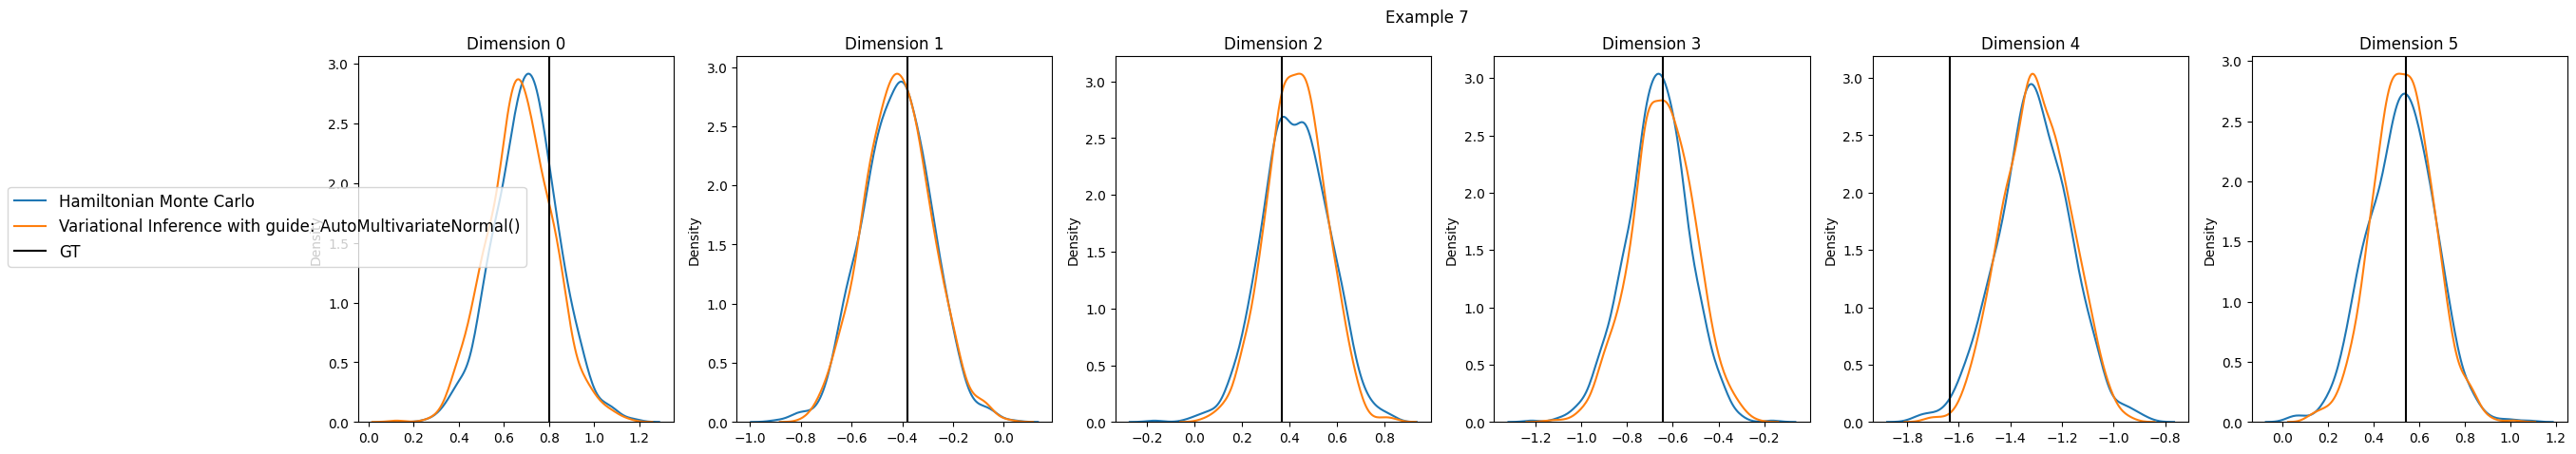

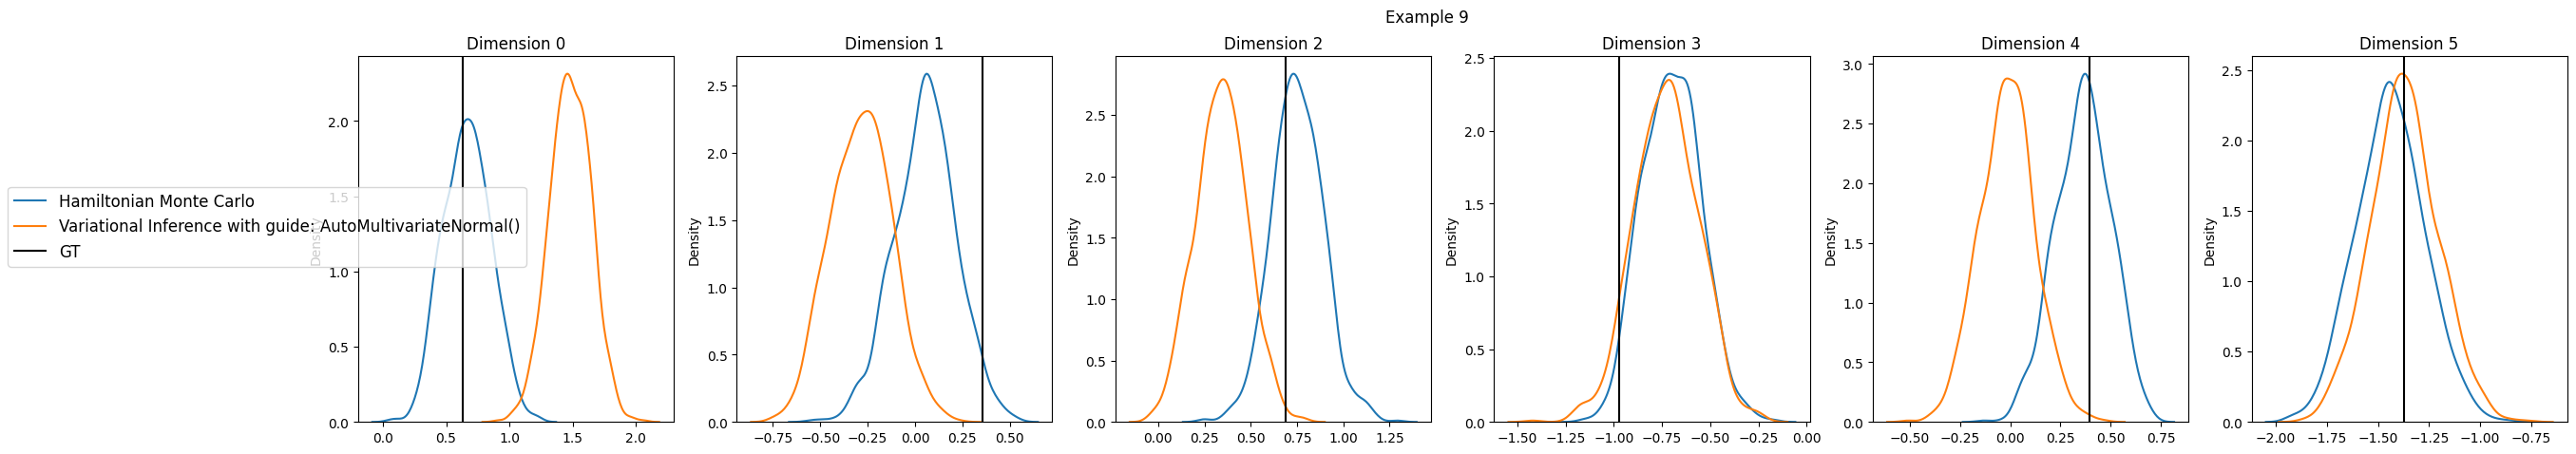

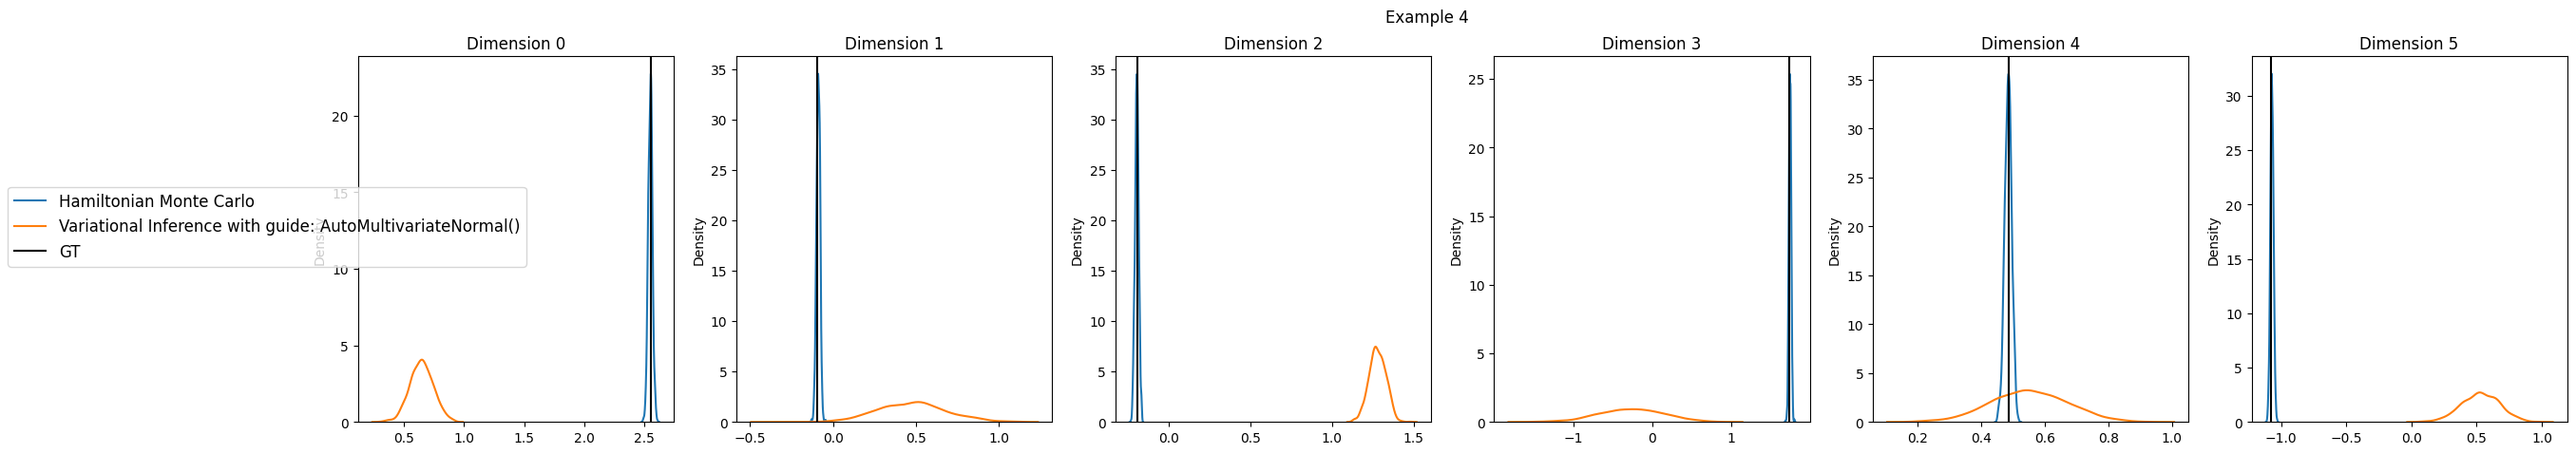

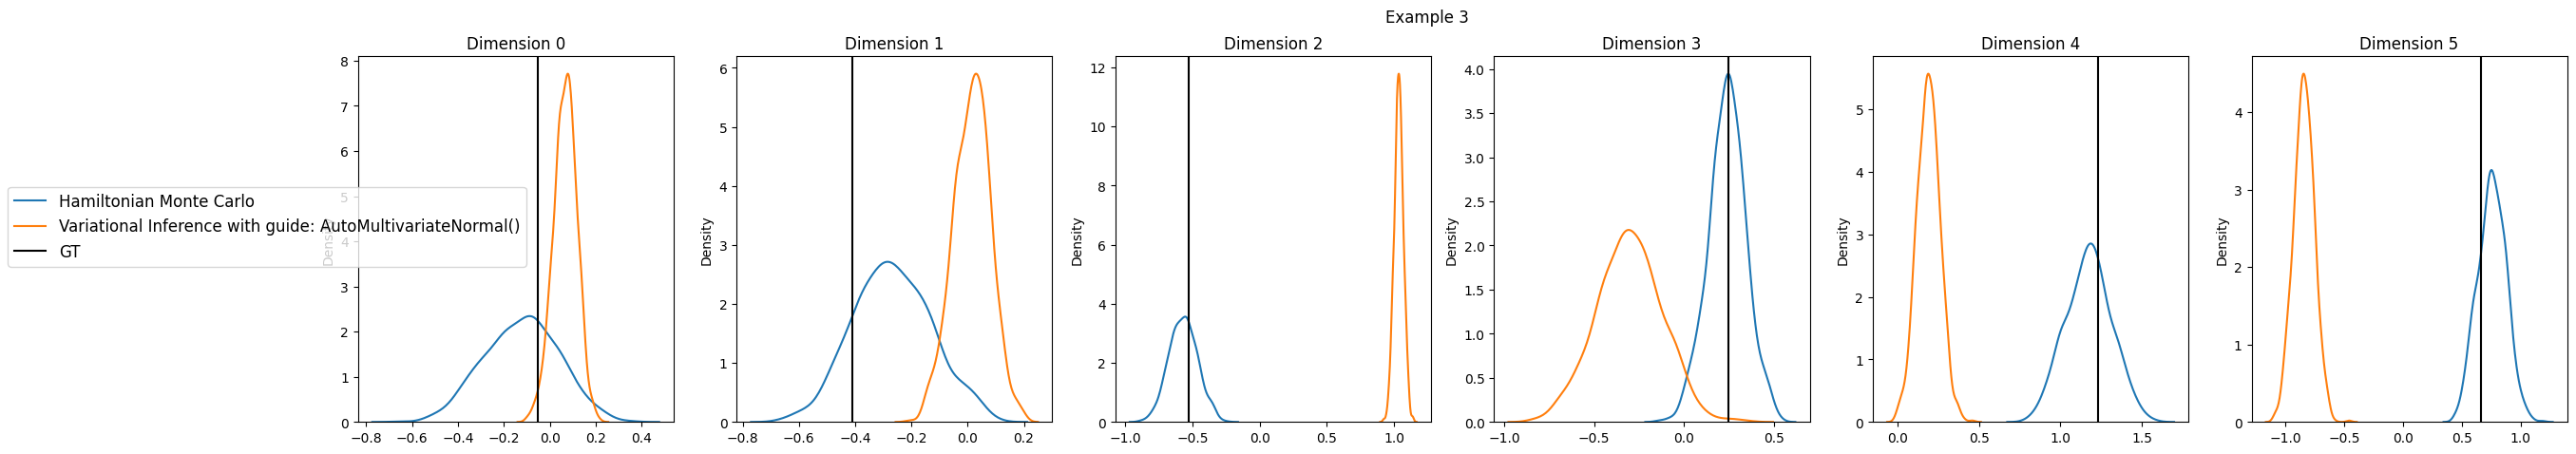

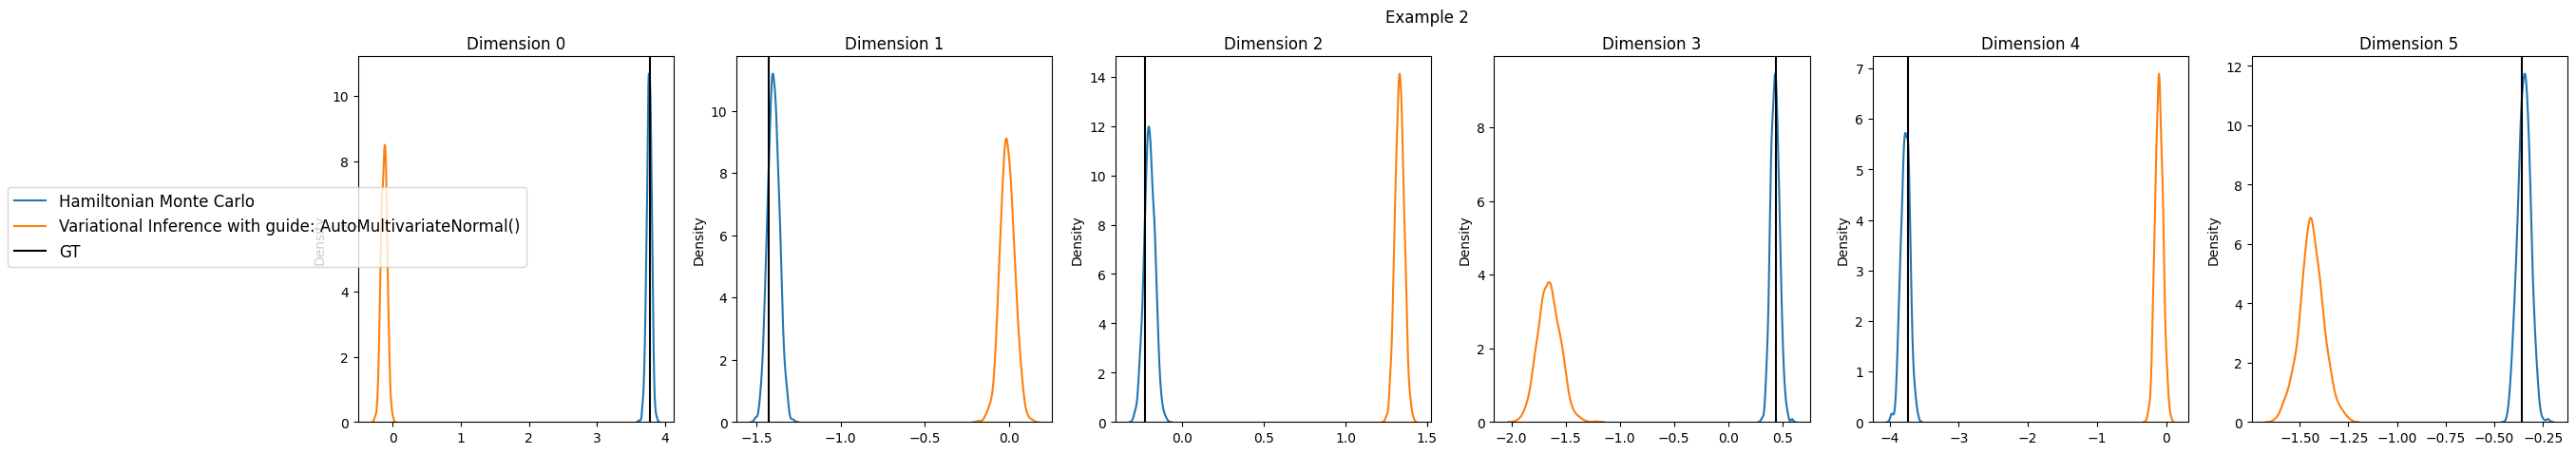

In [27]:
evaluation.plot_results()